# Intro

With the growth of machine learning due to moore's law, I wanted to know if it were possible to be able to programmatically transcribe podcasts using open-source technology and use those transcriptions to fulfill two things, all within an application:

* Provide me content recommendations based on episodes
* Provide me content recommendations based on contextual search

This notebook will provide an understanding of what was achiveved to accomplish this. 

For simplicity purposes we will breakdown each section of the pipeline and engineering process.

## Business Concept

The end goal for this capstone project was to create a real application that could be accessed by users. Podcasts have continued to grow at an alarming rate (more listeners than users on Twitter, a listener listens to 5 podcasts on average a week) but yet Apple has not innovated to capture this growth. The belief is with  a successful platform, we could capture a significant number of users and grow into a successful startup.


# Part I: Downloading the Source

Retrieval of podcasts was no easy feat. The most difficult thing was finding where these podcasts were self-hosted. Fun fact, Apple actually doesn't own or host the podcats, and podcast creator needs to self host an xml file which points to the metadata as well as the podcast the location. The thought was if I could find teh actual podcast location, I could use python to download and store the podcasts. The following simple script worked:

In [2]:
import pandas as pd
import numpy as np
import urllib2
import re
import wget
import os


os.chdir('/Users/sheldon/git/springboard_capstone/acquire_podcasts')
df = pd.read_csv('top100_pcasts_locations.csv')
urls = df.url.tolist()
urls = filter(lambda string: 'feeds.' in string or 'feed.' in string, urls)
urls = urls[2:3]

def homepage(request):
    file = urllib2.urlopen(request)
    data = file.read()
    file.close()

    def get_mp3s(data):
        data = data.split()
        data = filter(lambda word: word.endswith('.mp3"') , data)
        data = list(set(data))
        return data
    data = get_mp3s(data)  

    def parse_mp3(urlstring):
        urlstring = re.split('url=', urlstring)[1]
        return urlstring.replace('"','')
    
    data = map(parse_mp3, data)

    return data

def download_mp3(podcastseries, urls):
    os.chdir('/Users/sheldon/git/springboard_capstone/acquire_podcasts')
    os.mkdir(urls.split('/')[-1])
    os.chdir(urls.split('/')[-1])
    mp3_list = []
    def download(episode):
        print 'downloading: ',episode
        episode = wget.download(episode)
        print 'downloaded: ',episode

    for number, episode in enumerate(podcastseries):
        if len(mp3_list) < 1:
            print number, ': ', episode
            mp3_list.append(episode)
            download(episode)
            print 'length: ',len(mp3_list)
        else:
            break
    os.chdir('/Users/sheldon/git/springboard_capstone/acquire_podcasts')
    
for number, series in enumerate(urls):
    print 'starting: ',number, ' - ',series
    data = homepage(series)
    download_mp3(data, series)
    print 'completed: ',number, ' - ',series


starting:  0  -  http://feeds.wnyc.org/radiolab
0 :  http://feeds.wnyc.org/~r/radiolab/~5/sjLljunqqYg/radiolab111314.mp3
downloading:  http://feeds.wnyc.org/~r/radiolab/~5/sjLljunqqYg/radiolab111314.mp3
downloaded:  radiolab111314.mp3
length:  1
completed:  0  -  http://feeds.wnyc.org/radiolab


If you look above you can see that we are accessing a csv file that has the locations of the podcasts, taking the html data and parsing it, to look for any words that end with ".mp3" and then enacting our download_mp3 function to download each podcast into it's own folder. I orginally was downlaoding from the top 30 podcasts and transcrbing 11 episodes.

## Part II: Transcription

Doing some research it appears that there is a fantastic plugin called pyAudio. PyAudio uses C based dependencies and can be linked to private API's or can be used with an open-source technology called CMU Sphinx. The detailed explanation of how CMU Sphinx is able to transcribe is not covered in this report as digital signal processing and audio processing is anything bu trivial, but for a quick version and extremely simple explanation. We are basically taking the mp3 files and transforming them to wav files. From the wav files we are able to split the file up by looking for silences, and then break down each ofm those words into 10 millisecond partitions. We use a Hidden Markov Model to do the recognition of the words. I highly recommend checking out http://cmusphinx.sourceforge.net/wiki/tutorialconcepts .

Thankfully some wonderful researchers were able to place this into the library of speechRecognition, the code looks like the following (note this requires dependencies for install pockesphinx. You can do so with homebrew (brew install portaudio) pip install pyaudio, pip install speechRecognition:

In [3]:
from IPython.display import Audio
import speech_recognition as sr
r = sr.Recognizer()

In [4]:
with sr.Microphone() as source:
    print("Say something!")
    audio = r.listen(source)

Say something!


In [5]:
%%time
print(r.recognize_sphinx(audio))

testing testing one two three
CPU times: user 1.87 s, sys: 139 ms, total: 2.01 s
Wall time: 2.58 s


If you ran into problems running the code above, you will need to look into installing your dependencies: https://pypi.python.org/pypi/SpeechRecognition/

The next step was comparison of the different options for transcription. I compared the open-source CMU vs Waston API. Since I decided to stick with CMU I will not be including the code to transcribe using Watson, but I did compare two samples to see what the drop off would be:

In [6]:
from nltk.corpus import stopwords
from collections import Counter
import pandas as pd
import numpy as np
import nltk.data
from __future__ import division  # Python 2 users only
import nltk, re, pprint
from nltk import word_tokenize

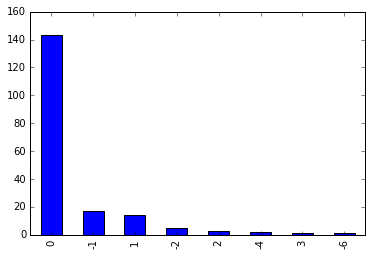

In [8]:
os.chdir("/Users/sheldon/git/springboard_capstone/")
cmu_trans = open('report_assets/transcription_cmu.txt','rU').read()
wat_trans = open('report_assets/transcription_watson_2.txt','rU').read()
stop = set(stopwords.words('english'))

## Tokenize and Lower the Words

def tokenize_and_lower(textfile):
    tokens = word_tokenize(textfile)
    lower = [w.lower() for w in tokens]
    filtered_words = [word for word in lower if word not in stop]
    series = pd.Series(filtered_words)
    return series

## Compare results with value counts, presuming that Watson is more accurate than CMU

cmu = tokenize_and_lower(cmu_trans)
wat = tokenize_and_lower(wat_trans)
cmu = pd.Series.to_frame(cmu)
wat = pd.Series.to_frame(wat)
cmu.columns = [['words']]
wat.columns = [['words']]
cmu = cmu.groupby('words').size().reset_index()
wat = wat.groupby('words').size().reset_index()
df = pd.merge(cmu, wat, on='words')
df.columns = [['words','cmu','wat']]
df['cmu_diff_wat'] = df.cmu - df.wat

%matplotlib inline
df.cmu_diff_wat.value_counts().plot(kind='bar')

In [9]:
df.cmu_diff_wat.value_counts()

 0    143
-1     17
 1     14
-2      5
 2      3
-4      2
 3      1
-6      1
Name: cmu_diff_wat, dtype: int64

What the code above is doing, is taking the the small transcription of a text file, removing useless words (commonly known as stopwords, NLTK has a module for 2400 stopwords, and grouping by word then comparing the differences by taking the word counts for CMU and comparing that to Watson. 143 of the words had the same count, which is a measure of 76% (143 / 186). That was enough for me to go with CMU, as I could also parallelize CMU to run multiple podcasts at a time and not pay for API calls to transcribe.

Once I had my set of podcasts, I decided that I would first attempt to transcribe locally. This actaully took quite a long time as I ended up having issues with my mac falling asleep or the process crashing due to running out of memory. I finalized on separating out the files based on the series and individually running the transcription using the command line. This took a long time as I would run the script before work, after work and going to bed. Moving forward, as this project is something I am continuing to build out and use, I will be using Spark and AWS as an option for scaling transcription.

To Transform a full podcast I had to do several things:

1. Take the mp3 and turn it into a wav. I used ffmpeg and the speech_recognition library
2. Slice up each wav file into 300 seconds
3. Transcribe those 300 seconds into a text file
4. Save the transcription into an array of text files and concatenate the files together
5. Remove the wav files as they take up a lot of memory.

In [10]:
#example code

from pydub import AudioSegment
import glob
from math import ceil
import os
import json
import csv
import sys
import speech_recognition as sr
r = sr.Recognizer()

def transcribe_mp3(AUDIO_FILENAME, AUDIO_SEGMENT_SECONDS):
    output_file_name = "{}_translation.txt".format(AUDIO_FILENAME)
    #fuction to transform mp3 file to wav for transcription
    try:
        def transform_mp3_wav(AUDIO_FILENAME, AUDIO_SEGMENT_SECONDS):
            filename = AUDIO_FILENAME.replace('.mp3','')
            with open(AUDIO_FILENAME):
                audio = AudioSegment.from_mp3(AUDIO_FILENAME)
                xs = 0
                while xs < audio.duration_seconds:
                    ys = min(xs + AUDIO_SEGMENT_SECONDS, ceil(audio.duration_seconds))
                    fname = str(xs).rjust(5, '0') + '-' + str(ys).rjust(5, '0') + '.wav'
                    audio[xs*1000:ys*1000].export(os.getcwd() + '/' + filename + fname, format='wav')
                    print("Saved", fname)
                    xs = ys
        transform_mp3_wav(AUDIO_FILENAME, 300)
        wav_filename = AUDIO_FILENAME.replace('.mp3','.wav')
        wav_list = glob.glob('*.wav')
        wav_list = filter(lambda x: '.mp3' not in x, wav_list)
        trans_list = []
        transcription = None
        for wav_file in wav_list: 
            print 'transcribing: ' + wav_file
            with sr.AudioFile(wav_file) as source:
                audio = r.record(source)
                transcription = r.recognize_sphinx(audio)
                print 'transcription completed'
            trans_list.extend(transcription)
            
        transcription = ''.join(trans_list)
    except:
        return 'error'
    
    for f in wav_list:
        os.remove(f)
    
    file = open(output_file_name,'w')
    file.write(transcription)
    file.close()

After a lot of memory-errors and heart-ache I able to transcribe 150 podcasts from 11 different series. In the future I will be adding much more. I was able to take the transcriptions and write them to a no-sql database where I have the filepath, name of the series and the transcription. The dataframe is below:

In [11]:
import sqlite3

def connect_db():
	return sqlite3.connect('/Users/sheldon/podcasts/test.db')

def create_df_object():
	conn = sqlite3.connect('/Users/sheldon/podcasts/test.db')
	df = pd.read_sql("select * from podcast",conn)
	return df

df = create_df_object()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 5 columns):
index          151 non-null int64
episode        151 non-null object
locations      151 non-null object
series         151 non-null object
transcribed    151 non-null object
dtypes: int64(1), object(4)
memory usage: 6.0+ KB


As you can tell it's a fairly small dataframe, but with scaling I will be able to make this a much higher potential (I have 3K podcasts ready to transcribe in an s3 bucket, but need to finish the spark code).

## Part III: Unsupervised Learning Models: TFIDF & Cosine Similarity

The next step was looking how to create a recommendation engine based on the transcriptions of the podcast but not having a ground truth. It sounds like a perfect job for an unsupervised learning model. 

I originally started with using some simple NLP techniques which include TF-IDF and the cosine similarity.

TF-IDF was a model that was originally used by Google for creating their pageranking engine with regards to content. It involves two simple calculations:
* Term Frequency(t) = (Number of times term t appears in document)/(Total number of terms in the document)
* Inverse Document Frequency(t) = log_e(Total number of documents)/(Number of documents with term t in it)

Let's say I am looking for the word 'Clustering' and I have a document with 100 words and 'Clustering' appears in the document 3 times. TF = (3/100) = 0.03. If we had 1 million documen ts and the word clustering appears in 100 hundred of these then log(1 Million / 100) = 4. The TF-IDF weight is now 0.12.

source:http://www.tfidf.com/

So how can we use TF-IDF to create a recommendation engine, when each word actually has it's own TF-IDF weight? We will convert the documents to a document vector (or a vector space model) (an array of tf-idf numbers that show the value / importance of each word) and then take the dot product of the two vectors which results in transforming a vector into a scalar value (an actual number). We can then find the cosine similarity of the different documents. The measurement is one of orientation and not magnitude and we are able to use that to determine the angle and the 'similarity' of the documents. See the image below and this blog write up for more details: http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/

In [13]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "http://blog.christianperone.com/wp-content/uploads/2013/09/cosinesimilarityfq1.png")

Originally I was using sci-kit learn and tfidf_vectorizer as my method for calcualting the cosine similarity. As per normal, sci-kit learn makes implementation of machine learning models fairly trivial.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(stop_words=stop)
tfidf_matrix = tf.fit_transform(df['transcribed'])
tfidf_matrix

<151x35028 sparse matrix of type '<type 'numpy.float64'>'
	with 264535 stored elements in Compressed Sparse Row format>

That creates a tfidf_matrix of podcast to terms (151 podcasts and 35028 terms). Then we create the cosine similarities:

In [15]:
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)
print cosine_similarities
print len(cosine_similarities)

[[ 1.          0.59226052  0.54622254 ...,  0.54416222  0.55159127
   0.58625829]
 [ 0.59226052  1.          0.53865688 ...,  0.55823367  0.55673508
   0.5924624 ]
 [ 0.54622254  0.53865688  1.         ...,  0.50279116  0.49328254
   0.52602526]
 ..., 
 [ 0.54416222  0.55823367  0.50279116 ...,  1.          0.74494456
   0.78448461]
 [ 0.55159127  0.55673508  0.49328254 ...,  0.74494456  1.          0.75725121]
 [ 0.58625829  0.5924624   0.52602526 ...,  0.78448461  0.75725121  1.        ]]
151


You can see above that we were able to use our linear kernel from scikit learn to transform the tfidf_matrix and get the cosine similarities for every podcast related to every podcast!

Now we can put this into functions that can be usable for a user and future web app:

In [16]:
def get_related_podcasts_scikit(podcast_number,number_of_similarities):
    cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)
    related_pod_index = cosine_similarities.argsort()[podcast_number][::-1]
    pod_dict = dict(zip(range(0, len(related_pod_index)),related_pod_index))
    pod_dict = pd.DataFrame({'rank':pod_dict.keys()},index=pod_dict.values())
    related_podcasts_df = pd.DataFrame.join(pod_dict, df, how='inner')
    final_df = related_podcasts_df.sort_values('rank')[0:number_of_similarities+1][['rank','episode','series']]
    return final_df

def get_related_podcasts_query_scikit(query, number_of_similarities):
    query = query.lower()
    query = query.split()
    tfidf_matrix_test = tf.fit_transform(query)
    tfidf_matrix_train = tf.transform(df['transcribed'])
    tfidf_matrix_train.todense()
    tfidf_matrix_test.todense()
    query_similarities = linear_kernel(tfidf_matrix_test, tfidf_matrix_train)
    query_similarities = query_similarities.argsort()[0][::-1]
    pod_dict = dict(zip(range(0, len(query_similarities)),query_similarities))
    pod_dict = pd.DataFrame({'rank':pod_dict.keys()},index=pod_dict.values())
    related_podcasts_df = pd.DataFrame.join(pod_dict, df, how='inner')
    final_df = related_podcasts_df.sort_values('rank')[0:number_of_similarities+1][['rank','episode','series']]
    return final_df

I'm creating two functions here:

1. Retrieve the related podcasts based on the cosine similarity of that partciluar podcast compared to other podcasts.

2. Retrieve the related podcasts based on the cosine similarity of a particular phrase. 

For 1, we are computing the cosine similarities, pulling the podcast based on the index, creating a dictionary of each index and ranking, joining that to original dataframe, sorting it by the rank, and returning the data frame.

For 2, we are taking the query and doing some simple cleaning (lower and splitting into an array, transforming that array into a tfidf matrix, computing cosine similarity, and then copying the same thing as 1 with the the returned value being a dataframe. You can see the functions with their returned values below:

In [17]:
get_related_podcasts_query_scikit('trump clinton obama guns',5)

,rank,episode,series
105,0,snapjudgment012116_snap702_fullcircle.mp3_tran...,snapjudgment-wnyc
69,1,otm012916pod.mp3_translation.txt,onthemedia
53,2,4399611-4-6-16-mark-levin-audio-rewind.mp3_tra...,MLAR
50,3,4245343-2-29-16-mark-levin-audio-rewind.mp3_tr...,MLAR
86,4,Pumped-on-Trump_podcast.mp3_translation.txt,revealpodcast
54,5,4513041-5-2-16-mark-levin-audio-rewind.mp3_tra...,MLAR


In [18]:
get_related_podcasts_scikit(22,5)

,rank,episode,series
22,0,freakonomics_podcast010213.mp3_translation.txt,freakonomics
150,1,WS091715.mp3_translation.txt,wrestling_soup
145,2,TIMFERRISSSHOW019.mp3_translation.txt,thetimferrissshow
113,3,01 Ep. 12_ Judd Apatow.mp3_translation.txt,TheBillSimmonsPodcast
148,4,WS030416.mp3_translation.txt,wrestling_soup
135,5,05-Tim_Ferriss_Show-Chase_Jarvis_128.mp3_trans...,thetimferrissshow


Timing:

In [19]:
%timeit get_related_podcasts_query_scikit('economics math statistics',5)

1 loop, best of 3: 1.54 s per loop


In [20]:
%timeit get_related_podcasts_scikit(22,5)

10 loops, best of 3: 65.8 ms per loop


As mentioned before I originally implemented this model into the flask app, but noticed that for each query we had to recompute the cosine similarities, which wasn't sustainable. Thus I discovered Gensim, Topic Modeling for Humans.

## Part IV: Unsupervised Learning Models: Gensim & LSI

For anyone looking to play around with Gensim, I highly recommend the well documented API and the tutorials. Gensim, unlike scikit, actually has models that you can use to write to disk, which means the webserver could write the dictionary, corpus, and models all to disk and only need to read them once. Gensim also has a fantastic server module that the creator has just put out.

For gensim, it was a similar process to setup:

1. Clean the data (remove stopwords, capitalization, apostrophes)
2. Create the Corpus (a collection of text documents, in this case the transcriptions)
3. Create the TF-IDF Model
4. Create the LSI Model
5. Apply TFIDF on the corpus
6. Apply LSI on the TFIDF Matrix

LSI (Also known as LSA) does not only find similarities based on the cosine of the angle, but additionally can extract out topics of any two documents using a method called Singular Value Decomposition, to determine the pattern of relationships between teh terms and the concepts in an unstructured collection of text (https://en.wikipedia.org/wiki/Latent_semantic_analysis).

In translation we could feed in a list of podcasts transcriptions and be able to get the top related podcasts but also the themes which relate these podcasts.

We are also able to overcome a big issue of boolean keyword queries, that have similar meanings and words that have more than one meaning (IE "python internet" might return a coding podcast but "python jungle" might return a travel podcast.)

In [21]:
import gensim
os.chdir('/Users/sheldon/git/springboard_capstone/apps/')
dictionary = gensim.corpora.Dictionary.load('models/words.dict')
corpus = gensim.corpora.MmCorpus('models/corpus.mm')
tfidf = gensim.models.tfidfmodel.TfidfModel.load('models/tfidf_model')
lsi = gensim.models.lsimodel.LsiModel.load('models/model.lsi')
index = gensim.similarities.MatrixSimilarity.load('models/corpus.index')
corpus_tfidf = tfidf[corpus]
corpus_lsi = lsi[corpus_tfidf]

Here I loaded up all my models built off the podcast transcriptions, and built an LSI model with 50 different topics. Below is a sample of 10 of them.

In [22]:
lsi.print_topics(10)

[(0,
  u'-0.068*"republican" + -0.053*"movie" + -0.050*"conservative" + -0.048*"obama" + -0.046*"trump" + -0.044*"mortified" + -0.044*"health" + -0.040*"constitution" + -0.040*"government" + -0.039*"patients"'),
 (1,
  u'0.236*"republican" + 0.180*"conservative" + 0.169*"trump" + 0.155*"constitution" + 0.140*"tromp" + 0.138*"obama" + 0.127*"donald" + 0.127*"immigration" + 0.118*"establishment" + 0.097*"crews"'),
 (2,
  u'-0.193*"patients" + -0.148*"health" + 0.123*"j." + 0.109*"mortified" + -0.101*"philadelphia" + 0.096*"cops" + -0.096*"patient" + -0.093*"obesity" + 0.092*"j" + -0.089*"research"'),
 (3,
  u'-0.374*"taliban" + -0.293*"pakistan" + -0.290*"afghanistan" + 0.123*"mortified" + -0.110*"pakistani" + -0.103*"guantanamo" + -0.096*"j" + -0.095*"j." + -0.093*"cops" + -0.086*"military"'),
 (4,
  u'-0.309*"taliban" + -0.247*"afghanistan" + -0.233*"pakistan" + 0.157*"j." + 0.145*"j" + 0.140*"cops" + 0.107*"thirteenth" + 0.107*"tower" + 0.098*"detectives" + 0.098*"jay"'),
 (5,
  u'-0.

Looking through these topics you can immdiately see that there are some related themes, like 2 which has "republican, conservative, and trump, constitution". In fact, LSI has been tested by having a the machine cluster documents and having humans sort documents, and the results have been very similar.

Once we have our topics we need to create similar functions from before:

In [23]:
def get_related_podcasts(index):
    def getKey(item):
        return item[1]
    corpus = corpus_lsi[index]
    corpus = sorted(corpus, key=getKey, reverse=True)[0:10]
    related_df = pd.DataFrame(corpus,columns=['index','score'])
    final_df = pd.merge(related_df, df, on='index')[['index','episode','score','series']]
    return final_df

def get_related_podcasts_query(query):
    query = query.lower()
    vec_box = dictionary.doc2bow(query.split())
    vec_lsi = lsi[vec_box]
    sims = index[vec_lsi]
    sims = sorted(enumerate(sims), key=lambda item: -item[1])[0:10]
    related_df = pd.DataFrame(sims,columns=['index','score'])
    final_df = pd.merge(related_df, df, on='index')[['index','episode','score','series']]
    return final_df

In [24]:
get_related_podcasts(1)

,index,episode,score,series
0,11,Episode_16_Poster_Boy.mp3_m_reK.tmp_translatio...,0.156565,CriminalShow
1,9,Criminal.Ep14.FifthSuspectFINAL.mp3_translatio...,0.119628,CriminalShow
2,3,dopequeens041916_cms596223_pod.mp3_translation...,0.102187,2DopeQueens
3,2,dopequeens041216_cms593915_pod.mp3_translation...,0.094652,2DopeQueens
4,14,Episode_28__P.D.I.D..mp3_translation.txt,0.074682,CriminalShow
5,17,freakonomics_mppodcast071012.mp3_translation.txt,0.045444,freakonomics
6,5,dopequeens050316_cms600651_pod.mp3_translation...,0.042427,2DopeQueens
7,19,freakonomics_mppodcast103112.mp3_translation.txt,0.020345,freakonomics
8,20,freakonomics_mppodcast112812.mp3_translation.txt,0.016910,freakonomics
9,18,freakonomics_mppodcast100511.mp3_translation.txt,0.011356,freakonomics


In [25]:
get_related_podcasts_query("trump clinton obama guns")

,index,episode,score,series
0,53,4399611-4-6-16-mark-levin-audio-rewind.mp3_tra...,0.105772,MLAR
1,46,4019946-1-4-16-mark-levin-audio-rewind.mp3_tra...,0.093135,MLAR
2,52,4351605-3-25-16-mark-levin-audio-rewind.mp3_tr...,0.087484,MLAR
3,54,4513041-5-2-16-mark-levin-audio-rewind.mp3_tra...,0.071596,MLAR
4,50,4245343-2-29-16-mark-levin-audio-rewind.mp3_tr...,0.062403,MLAR
5,49,4205309-2-19-16-mark-levin-audio-rewind.mp3_tr...,0.053411,MLAR
6,86,Pumped-on-Trump_podcast.mp3_translation.txt,0.041023,revealpodcast
7,47,4077439-1-18-16-mark-levin-audio-rewind.mp3_tr...,0.035475,MLAR
8,56,4579716-5-17-16-mark-levin-audio-rewind.mp3_tr...,0.025987,MLAR
9,55,4574251-5-16-16-mark-levin-audio-rewind.mp3_tr...,0.020811,MLAR


In [28]:
%timeit get_related_podcasts(1)

10 loops, best of 3: 23.3 ms per loop


In [29]:
%timeit get_related_podcasts_query('economics math statistics')

100 loops, best of 3: 5.51 ms per loop


As you'd expect the speed is much faster without having to continuously do the cosine similarity computation. But also the results from an anecdotal perspective look much more accurate. MLAR is a popualr political podcast so it makes sense that it's been clustered in that politics topic. We can explore this further:

In [30]:
#get list of related podcasts
related_podcasts = list(get_related_podcasts(1)['index'])

In [31]:
def get_topics_per_podcast(podcast_index):
    def getKey(item):
        return item[1]
    topic_ids = [i for i in sorted(corpus_lsi[podcast_index], key=getKey, reverse=True) if i[1] > 0.10]
    def get_topic_arrays(topic_ids):
        x = []
        for id in topic_ids:
            list_of_words = sorted(lsi.show_topic(id[0], topn=5),key=getKey, reverse=True)
            z = []
            for word in list_of_words:
                if word[1] > .05:
                    z.append(word)
            x.append(z)
        return x
    topic_arrays = get_topic_arrays(topic_ids)
    return topic_arrays
related_podcasts_topics_words = [[related_podcasts[i],get_topics_per_podcast(related_podcasts[i])] for i in range(0, len(related_podcasts))]
episode_podcasts = list(get_related_podcasts(1)['episode'])
series_podcasts = list(get_related_podcasts(1)['series'])

In [32]:
for i,k in enumerate(related_podcasts_topics_words):
    print "Podcast: {}, ID: {}".format(i+1, k[0])
    print "Podcast Series: {}".format(series_podcasts[i])
    print "Episode Title: {}".format(episode_podcasts[i])
    for num, topic in enumerate(k[1]):
        print "topic: {}".format(num)
        for word in topic:
            print "word: {}, score:{}".format(word[0], word[1])

Podcast: 1, ID: 11
Podcast Series: CriminalShow
Episode Title: Episode_16_Poster_Boy.mp3_m_reK.tmp_translation.txt
topic: 0
word: tommy, score:0.13349055465
word: petrified, score:0.132104840356
word: elkins, score:0.124858606537
word: trump, score:0.112054639199
topic: 1
word: lakeview, score:0.162300386834
word: chandler, score:0.133973881945
topic: 2
word: dean, score:0.15605057081
word: police, score:0.0977091146594
topic: 3
word: movie, score:0.195235938874
word: movies, score:0.134115893759
word: assaulting, score:0.0923715665976
Podcast: 2, ID: 9
Podcast Series: CriminalShow
Episode Title: Criminal.Ep14.FifthSuspectFINAL.mp3_translation.txt
topic: 0
word: tommy, score:0.13349055465
word: petrified, score:0.132104840356
word: elkins, score:0.124858606537
word: trump, score:0.112054639199
topic: 1
word: tommy, score:0.13951262149
word: lakeview, score:0.0894430773747
topic: 2
word: dean, score:0.15605057081
word: police, score:0.0977091146594
topic: 3
word: vulnerability, score:0.

Looking through the print out, you can start to piece how episodes are related to each other.

## Part V: Next Steps

That about wraps up my capstone project. If you go to my repo you can clone it and try running the application. I am also trying to figure out how to push my flask app to heroku.